In [ ]:
from nbdev import *

In [10]:
%nbdev_default_export fluorescence_intensity

# Fluorescence intensity

> API details.

In [11]:
%nbdev_hide
from nbdev.showdoc import *

In [12]:
# %load common.py
%nbdev_export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from importlib import reload

In [13]:
%nbdev_export
from ehv import load
import flowutils
import ppscore
reload(load)

<module 'ehv.load' from 'd:\\dev\\active\\ehv-analysis\\ehv\\load.py'>

In [14]:
df_201 = load.remove_unwanted_features(load.load_raw_ideas("D:/Experiment_data/weizmann/EhV/201", load_labels=True))
df_control = load.remove_unwanted_features(load.load_raw_ideas("D:/Experiment_data/weizmann/EhV/control", load_labels=False))

# Inspect intensity distributions

## Infected samples

In [15]:
%nbdev_export
def apply_logicle(df, columns=["Intensity_MC_TMR", "Intensity_MC_Cy5", "Intensity_MC_DAPI"]):
    df = df.copy()

    for (t_idx, r_idx), group_df in df.groupby(["timepoint", "replicate"]):

        for feat in columns:

            y = group_df[[feat]].values

            df.loc[(df["timepoint"] == t_idx) & (df["replicate"] == r_idx), feat+"_logicle"] = \
                flowutils.transforms.logicle(y, numpy.arange(y.shape[1]), r_quant=True)

    return df

In [16]:
df_201 = apply_logicle(df_201)

### Distributions

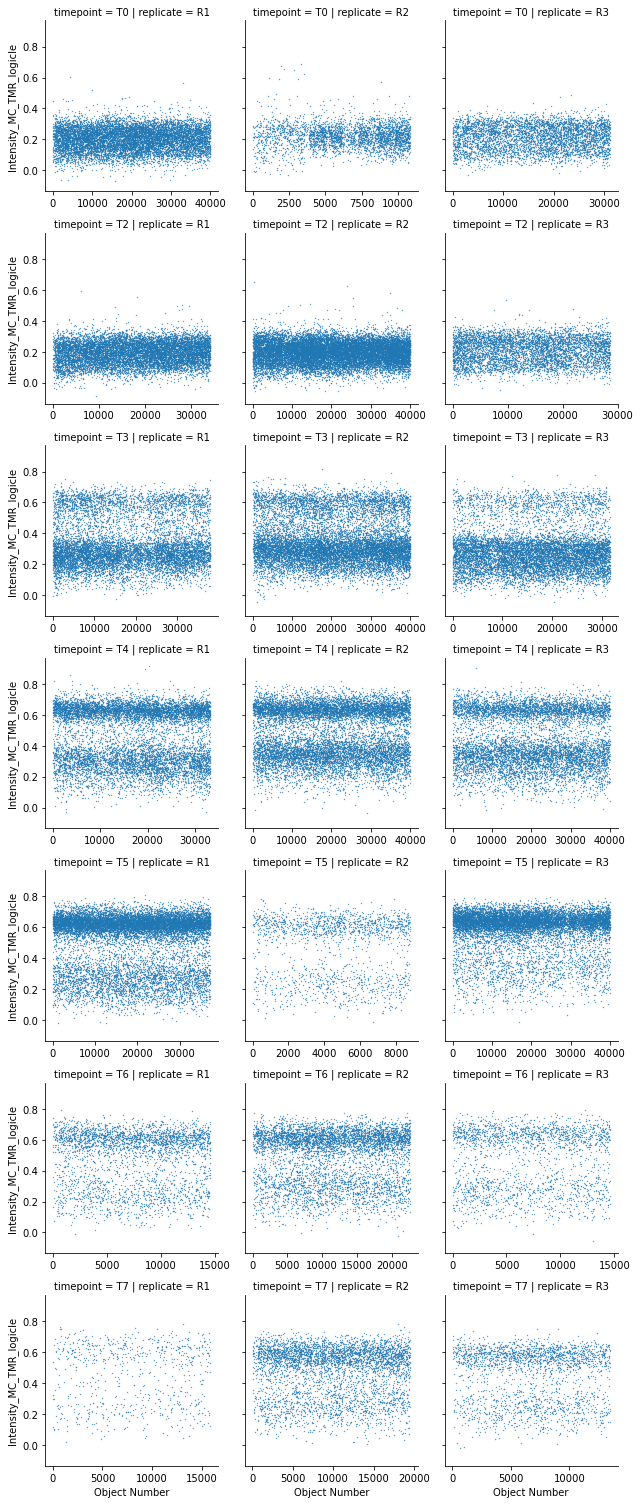

In [17]:
grid = seaborn.FacetGrid(df_201.reset_index(), col="replicate", row="timepoint", sharex=False)
grid = grid.map(plt.scatter, "Object Number", "Intensity_MC_TMR_logicle", s=0.1)

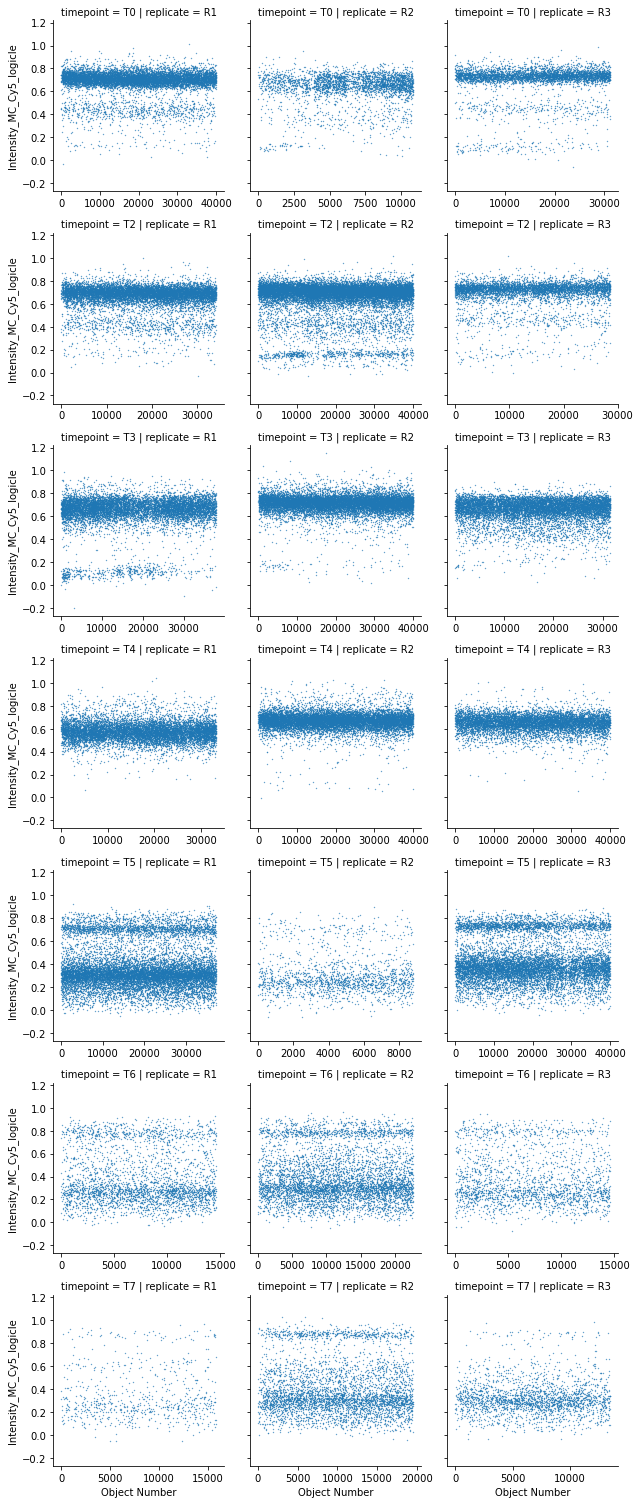

In [18]:
grid = seaborn.FacetGrid(df_201.reset_index(), col="replicate", row="timepoint", sharex=False)
grid = grid.map(plt.scatter, "Object Number", "Intensity_MC_Cy5_logicle", s=0.1)

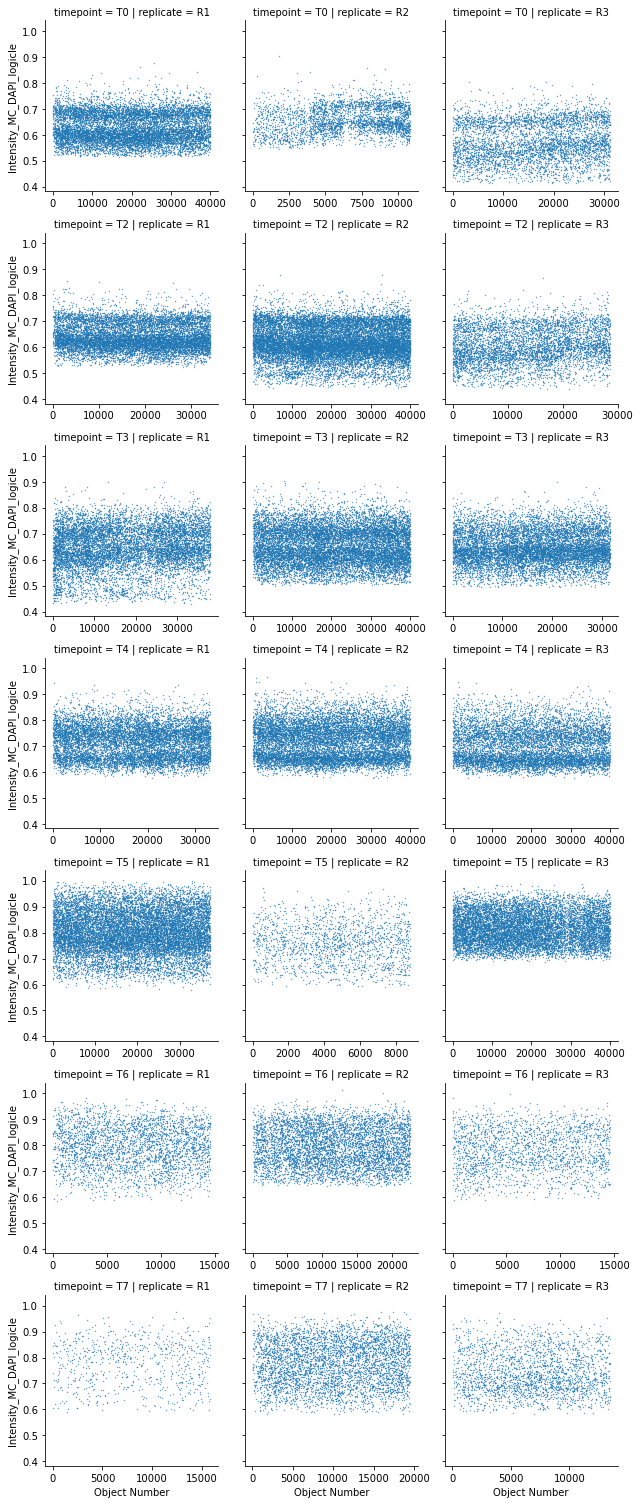

In [19]:
grid = seaborn.FacetGrid(df_201.reset_index(), col="replicate", row="timepoint", sharex=False)
grid = grid.map(plt.scatter, "Object Number", "Intensity_MC_DAPI_logicle", s=0.1)

### Predictive Power Score

In [20]:
df = df_201.loc[:, df_201.filter(regex=".*logicle").columns]
df["target"] = df_201["timepoint"] + df_201["replicate"]

result = ppscore.predictors(df, "target")

(0.0, 1.0)

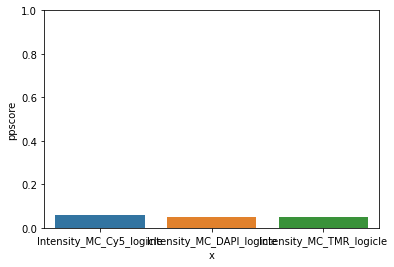

In [21]:
fig, ax = plt.subplots()
seaborn.barplot(data=result, x="x", y="ppscore", ax=ax)
ax.set_ylim(0, 1)

## Control samples

In [156]:
df_control = apply_logicle(df_control)

### Distributions

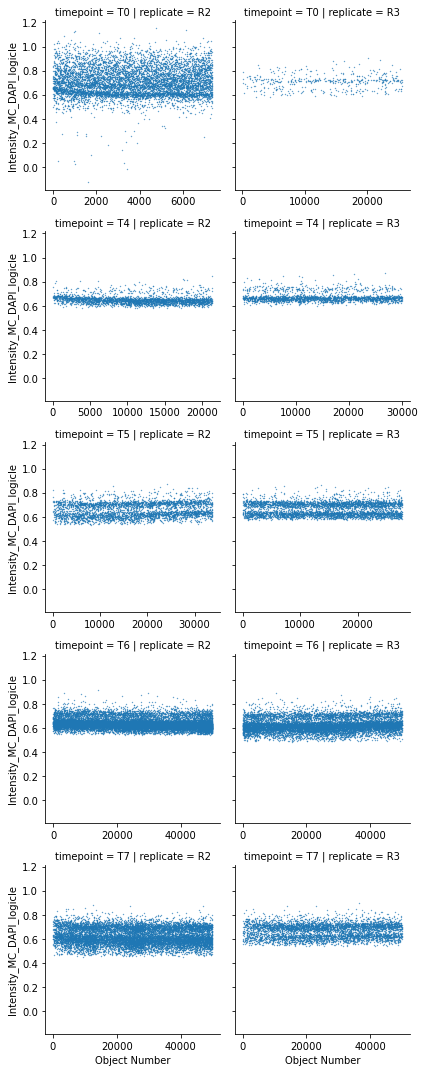

In [157]:
grid = seaborn.FacetGrid(df_control.reset_index(), col="replicate", row="timepoint", sharex=False)
grid = grid.map(plt.scatter, "Object Number", "Intensity_MC_DAPI_logicle", s=0.1)

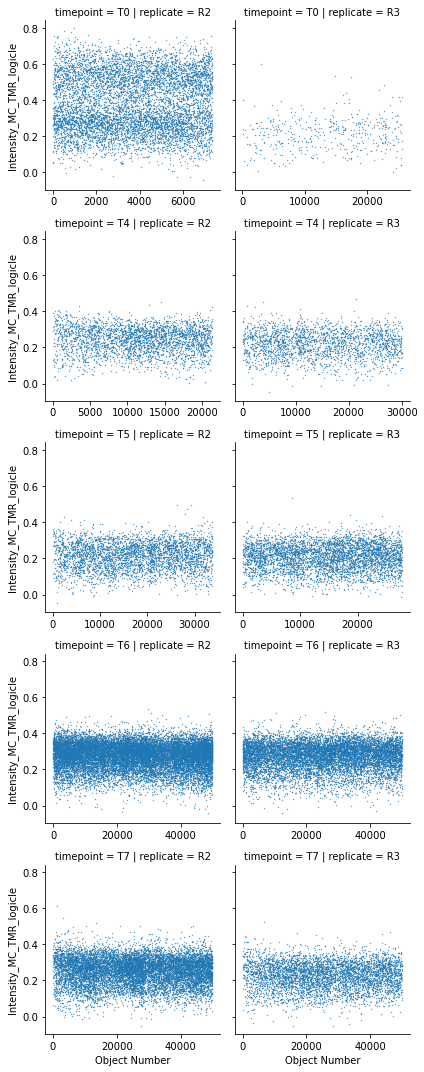

In [158]:
grid = seaborn.FacetGrid(df_control.reset_index(), col="replicate", row="timepoint", sharex=False)
grid = grid.map(plt.scatter, "Object Number", "Intensity_MC_TMR_logicle", s=0.1)

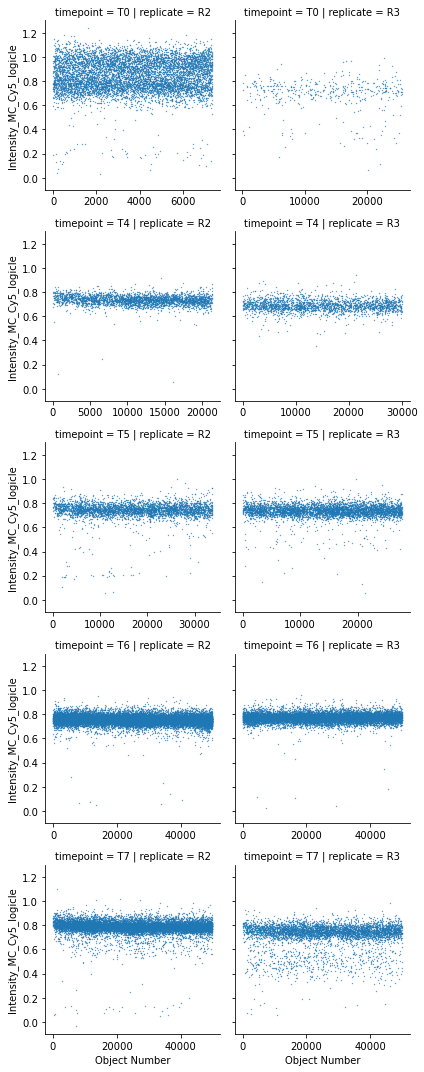

In [182]:
grid = seaborn.FacetGrid(df_control.reset_index(), col="replicate", row="timepoint", sharex=False)
grid = grid.map(plt.scatter, "Object Number", "Intensity_MC_Cy5_logicle", s=0.1)

### Predictive Power Score

In [160]:
df = df_control.loc[:, df_control.filter(regex=".*logicle").columns]
df["target"] = df_control["timepoint"] + df_control["replicate"]

result = ppscore.predictors(df, "target")

(0.0, 1.0)

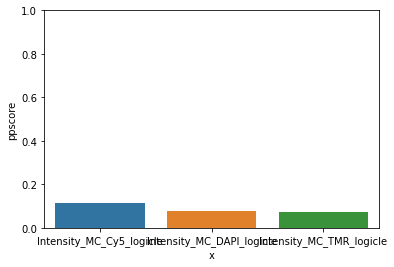

In [161]:
fig, ax = plt.subplots()
seaborn.barplot(data=result, x="x", y="ppscore", ax=ax)
ax.set_ylim(0, 1)

# Export for PeacoQC

In [22]:
from ehv import export
reload(export)

<module 'ehv.export' from 'd:\\dev\\active\\ehv-analysis\\ehv\\export.py'>

In [23]:
for (t_idx, r_idx), grouped_df in df_201.groupby(["timepoint", "replicate"]):
    tmp_df = grouped_df[["Intensity_MC_TMR", "Intensity_MC_Cy5", "Intensity_MC_DAPI", "Intensity_MC_TMR_logicle", "Intensity_MC_Cy5_logicle", "Intensity_MC_DAPI_logicle", "label"]].copy()
    tmp_df["Time"] = grouped_df.index
    export.to_fcs(tmp_df, os.path.join("D:/Experiment_data/weizmann/EhV/201/", t_idx, r_idx, f"fluor_{t_idx}_{r_idx}.fcs"), encode=["label"])

In [198]:
for (t_idx, r_idx), grouped_df in df_control.groupby(["timepoint", "replicate"]):
    tmp_df = grouped_df[["Intensity_MC_TMR", "Intensity_MC_Cy5", "Intensity_MC_DAPI", "Intensity_MC_TMR_logicle", "Intensity_MC_Cy5_logicle", "Intensity_MC_DAPI_logicle"]].copy()
    tmp_df["Time"] = grouped_df.index
    export.to_fcs(tmp_df, os.path.join("D:/Experiment_data/weizmann/EhV/control/", t_idx, r_idx, f"fluor_{t_idx}_{r_idx}.fcs"), encode=[])

See scripts/PeacoQC.Rmd for analysis in R. QC showed no problematic files.

In [24]:
export.to_fcs(
    df_201[["Intensity_MC_TMR", "Intensity_MC_Cy5", "Intensity_MC_DAPI", "Intensity_MC_TMR_logicle", "Intensity_MC_Cy5_logicle", "Intensity_MC_DAPI_logicle"]],
    "D:/Experiment_data/weizmann/EhV/201/aggregates/fluor_T0234567_R123.fcs",
    encode=[]
)